In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

[0 0] [ 0.01985518 -0.07037065] nan
[ 0.01985518 -0.07037065] [-0.09716867 -0.32629479] 0.155108734719398
[-0.09716867 -0.32629479] [-0.06443086 -0.60152374] 0.016647985231725837
[-0.06443086 -0.60152374] [ 0.20685919 -0.59324616] 0.09619336012837187
[ 0.20685919 -0.59324616] [ 0.04028719 -0.11983746] 6.266829953027742e-05
[ 0.04028719 -0.11983746] [-0.06879296 -0.02202881] 1.0144100405854337
[-0.06879296 -0.02202881] [0.08683738 0.12032229] 1.8046273435350197
[0.08683738 0.12032229] [0.25068108 0.08606086] 0.18319739860463657
[0.25068108 0.08606086] [0.49551415 0.07382525] 0.016661736090310186
[0.49551415 0.07382525] [0.61426704 0.27959954] 0.03873772511597062


e:\venvs\general\lib\site-packages\scipy\spatial\distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


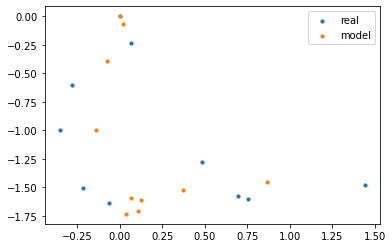

In [2]:
class MotionModel:
    def __init__(self, position, friction=0.7):
        assert 0 <= friction <= 1

        self.position = position.copy()
        self.velocity = np.array([0, 0])
        self.friction = friction

    def update(self, position):
        self.velocity = (self.friction * self.velocity +
                         (1 - self.friction) * (position - self.position))
        self.position += self.velocity

def rand_position_step(a=-1, b=1):
    return np.random.random(2) * (b - a) + a

position = np.array([0, 0], dtype=np.float)
model = MotionModel(position)
n_iterations = 10
iterations = np.arange(0, n_iterations)

positions_real = []
positions_model = []

for i in iterations:
    positions_real.append(position.copy())
    positions_model.append(model.position.copy())
    prev_velocity = model.velocity.copy()
    step = rand_position_step()
    position += step
    model.update(position)
    print(f'{prev_velocity} {model.velocity} {cosine(prev_velocity, model.velocity)}')

positions_real = np.array(positions_real)
positions_model = np.array(positions_model)

plt.scatter(positions_real[:, 0], positions_real[:, 1], s=10, label='real')
plt.scatter(positions_model[:, 0], positions_model[:, 1], s=10, label='model')
plt.legend()
plt.show()

In [3]:
from scipy.spatial.distance import cosine

a = np.array([1, 2])
b = np.array([1, 6])
scale = 0.1
np.tanh(scale * np.linalg.norm(a - b))

0.3799489622552249

In [4]:
from skimage.metrics import structural_similarity as ssim

img = cv.imread('../data/cars.jpg').astype(np.float)
ssim(img, img + 0.9 * np.random.random(img.shape), multichannel=True)

0.999103003493683

In [5]:
import json
import numpy as np
import cv2 as cv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.applications.mobilenet import preprocess_input

In [6]:
img_height, img_width, img_depth = 224, 224, 3

if K.image_data_format() == 'channels_first':
    input_shape = (img_depth, img_height, img_width)
else:
    input_shape = (img_height, img_width, img_depth)

def image_show(img):
    cv.imshow('Preview', img)
    cv.waitKey(0)
    cv.destroyAllWindows()

def image_read(img_file_path, width=img_width, height=img_height):
    img = cv.imread(img_file_path, cv.IMREAD_COLOR)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return cv.resize(img, (width, height))

img_query = image_read('../data/snapshots/03.png')
img_gt = image_read('../data/snapshots/02.png')

image_show(img_query)
image_show(img_gt)

In [7]:
with open('../model/embedding_model_layout.json', 'r') as json_file:
    content = json.load(json_file)
    embedding_model = keras.models.model_from_json(json.dumps(content))
embedding_model.load_weights('../model/embedding_model_weights.h5')
embedding_model.summary()

Model: "embedding_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)  

In [8]:
def get_embedding(img):
    return embedding_model.predict(np.array([preprocess_input(img)]))[0]

query_emb = get_embedding(img_query)
gt_emb = get_embedding(img_gt)

np.linalg.norm(query_emb - gt_emb)

0.35366675

In [11]:
import json

config = {
    'detector': {
        'config_file_path': '../model/yolov3.cfg',
        'weights_file_path': '../model/yolov3.weights',
        'labels_file_path': '../model/coco.names',
        'score_thresh': 0.5,
        'nms_thresh': 0.3,
        'use_gpu': False,
    },
    'tracker': {
        'config_file_path': '../model/embedding_model_layout.json',
        'weights_file_path': '../model/embedding_model_weights.h5',
        'iou_dist_thresh': 0.7,
        'emb_dist_thresh': 0.5,
        'max_no_update_count': 30,
    }
}

with open('../config_files/01.json', 'wt') as json_file:
    json_file.write(json.dumps(config, indent=2))

In [30]:
def get_cmap(n, name='Spectral'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

n = 10
cmap = get_cmap(n)
for i in range(n):
    color = np.array(cmap(i)[:3]) * 255
    print(color)
    img = (np.ones((500, 500, 3)) * color).astype(np.uint8)
    image_show(img)

[158.   1.  66.]
[216.44444444  67.22222222  77.66666667]
[246.         123.44444444  73.66666667]
[253.33333333 190.66666667 111.        ]
[254.44444444 237.77777778 162.11111111]
[241.11111111 249.44444444 169.33333333]
[190.66666667 229.         160.        ]
[117.33333333 200.         164.77777778]
[ 55.77777778 142.44444444 186.33333333]
[ 94.  79. 162.]
